In [4]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install rdkit
# !pip install mordred
# !pip install padelpy

!pip install torchsummary
!pip install matplotlib

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

1.13.1+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 41.9 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.7/299.7 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.7 MB/s eta 0:00:00


In [635]:
import pandas as pd
from rdkit import Chem

from torch.utils.data import DataLoader, Dataset
from torch_geometric.utils import to_networkx
src = "../app/dataset/"

class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, edge_adj_matrix, mask, mol_ids):
        self.edge_adj_matrix = edge_adj_matrix
        self.mask = mask
        self.x = x
        self.y = y
        self.mol_ids = mol_ids
        
        # Drop NaN values from input x and y
        # nan_indices = np.logical_or(np.isnan(x).any(axis=1), np.isnan(y))
        # self.x = x[~nan_indices]
        # self.y = y[~nan_indices]
        
        # Standardize input x
        # self.x_mean = torch.mean(self.x, dim=(0,2), keepdim=True)
        # self.x_std = torch.std(self.x, dim=(0,2), keepdim=True)
        # self.x = (self.x - self.x_mean) / self.x_std

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        edge_adj = self.edge_adj_matrix[index]
        mask = self.mask[index]
        mol_id = self.mol_ids[index] if index in self.mol_ids else None
        return x, y, edge_adj, mask, mol_id

    def __len__(self):
        return self.x.shape[0]

def create_dataset(sdf_file, shift_file, atom_symbols, convert_to_zero_index=False):
  df_shifts = pd.read_csv(shift_file, dtype={'atom_index': int, 'Shift': float, 'mol_id': str})
  suppl = Chem.ForwardSDMolSupplier(sdf_file, removeHs=False)
  # Convert 1-indexed chemical shift values to 0-indexed as in holdout set 2 for h
  if convert_to_zero_index: df_shifts['atom_index'] = df_shifts['atom_index'].apply(lambda x: x - 1)

  data = []
  for mol in suppl:
    if mol is not None:
      # Extract the mol_id from the molecule name
      mol_id = str(mol.GetProp('_Name'))

      # Filter out non-Hydrogen atoms
      atom_indexes = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetSymbol() in atom_symbols]

      # Extract the chemical shifts for the Hydrogen atoms
      shifts = df_shifts.loc[df_shifts['mol_id'] == mol_id]
      shifts = shifts.loc[shifts['atom_index'].isin(atom_indexes)]
      shifts = shifts[['atom_index', 'Shift']].set_index('atom_index')['Shift'].to_dict()

      # Construct a dictionary with the molecular information and chemical shifts
      mol_dict = {'mol_id': mol_id, 'mol': mol, 'num_atoms': len(mol.GetAtoms()), 'smiles': Chem.MolToSmiles(mol)}
      mol_dict.update({'labels': shifts})
      data.append(mol_dict)

  # Construct a dataframe with one row for each molecule in the batch
  return pd.DataFrame(data).dropna()

def split_train_validation_sets(dataset, num_valid_samples):
  valid = dataset.sample(n=num_valid_samples, random_state=125)
  train = dataset[~dataset.mol_id.isin(valid.mol_id)]

  #valid.to_pickle('valid.pkl.gz', compression='gzip')
  #train.to_pickle('train.pkl.gz', compression='gzip')
  return valid, train

shift_file_c = src + 'wishart_train_C_shifts.csv'
sdf_file_c = src + 'wishart_train_C.sdf'

test_shift_file_h = src + 'wishart_holdout_H_shifts_1.csv'
test_sdf_file_h = src + 'wishart_holdout_H_1.sdf'

test_shift_file_c = src + 'wishart_holdout_C_shifts_1.csv'
test_sdf_file_c = src + 'wishart_holdout_C_1.sdf'

# Create dataset and split it into train and validation sets pickle files
c_dataset = create_dataset(sdf_file_c, shift_file_c, ['C'])

shift_file_h = src + 'wishart_train_H_shifts.csv'
sdf_file_h = src + 'wishart_train_H.sdf'

h_dataset = create_dataset(sdf_file_h, shift_file_h, ['H'])

shift_file_cascade_h = src + 'DFT8K.csv'
sdf_file_cascade_h = src + 'DFT.sdf'
shift_file_cascade_c = src + 'Exp5K.csv'
sdf_file_cascade_c = src + 'FF.sdf'
sdf_file_cascade_c_dft = src + 'DFT_C.sdf'

#dataset = create_dataset(sdf_file, shift_file, 'H') 
#dataset = pd.concat([c_dataset, h_dataset])
#print(dataset.head())
#cascade_dataset_h = create_dataset(sdf_file_cascade_h, shift_file_cascade_h, ['H'])
#cascade_dataset_c_dft = create_dataset(sdf_file_cascade_h, shift_file_cascade_h, ['C'])
#cascade_dataset_c = create_dataset(sdf_file_cascade_c, shift_file_cascade_c, ['C'])
# DFT dataset for carbon is in there
#dataset = pd.concat([c_dataset, h_dataset, cascade_dataset_c, cascade_dataset_h])
dataset = pd.concat([cascade_dataset_c, c_dataset])

valid_df, train_df = split_train_validation_sets(dataset, 250)
test_df_c = create_dataset(test_sdf_file_c, test_shift_file_c, ['C'])
test_df_h = create_dataset(test_sdf_file_h, test_shift_file_h, ['H'])

print(test_df_c.head())
print('Full dataset length', len(train_df))
print('Valid dataset length', len(valid_df))
print('C Test dataset length', len(test_df_c))
print('H Test dataset length', len(test_df_h))


      mol_id                                               mol  num_atoms  \
0  NP0002702  <rdkit.Chem.rdchem.Mol object at 0x7efb0da50900>         17   
1  NP0002836  <rdkit.Chem.rdchem.Mol object at 0x7efb0da50430>         24   
2  NP0032148  <rdkit.Chem.rdchem.Mol object at 0x7efb0b6bdf20>         53   
3  NP0040877  <rdkit.Chem.rdchem.Mol object at 0x7efb0b6bddd0>         84   
4  NP0030850  <rdkit.Chem.rdchem.Mol object at 0x7efb0b6bde40>         28   

                                              smiles  \
0    [H]Oc1c([H])c([H])c([H])c(C([H])([H])[H])c1O[H]   
1  [H]OS(=O)(=O)N([H])C1([H])C([H])([H])C([H])([H...   
2  [H]OC(=O)/C([H])=C(\C([H])([H])[H])C([H])([H])...   
3  [H]OC([H])([H])[C@@](O[H])(C([H])([H])[H])[C@@...   
4  [H]O[C@]([H])(C(=C([H])[H])C([H])([H])[H])C([H...   

                                              labels  
0  {1: 129.28, 7: 144.72, 2: 125.25, 5: 146.94, 0...  
1  {5: 56.07, 10: 36.02, 6: 36.02, 9: 27.4, 7: 27...  
2  {0: 23.76, 1: 172.06, 2: 131.36,

[13:22:23] ERROR: Cannot convert '  R' to unsigned int on line 929
[13:22:23] ERROR: moving to the beginning of the next molecule
[13:22:23] ERROR: Counts line too short: '' on line2109
[13:22:23] ERROR: moving to the beginning of the next molecule
[13:22:23] ERROR: Counts line too short: '' on line2750
[13:22:23] ERROR: moving to the beginning of the next molecule
[13:22:23] ERROR: Counts line too short: '' on line3078
[13:22:23] ERROR: moving to the beginning of the next molecule
[13:22:23] ERROR: Cannot convert '  R' to unsigned int on line 4033
[13:22:23] ERROR: moving to the beginning of the next molecule
[13:22:23] ERROR: Cannot convert '  R' to unsigned int on line 4575
[13:22:23] ERROR: moving to the beginning of the next molecule
[13:22:23] ERROR: Counts line too short: '' on line7392
[13:22:23] ERROR: moving to the beginning of the next molecule


In [636]:
print('Full dataset length', len(train_df))
print('Valid dataset length', len(valid_df))

test_shift_file_c = src + 'wishart_holdout_C_shifts_2.csv'
test_sdf_file_c = src + 'wishart_holdout_C_2.sdf'

test_shift_file_h = src + 'wishart_holdout_H_shifts_2.csv'
test_sdf_file_h = src + 'wishart_holdout_H_2.sdf'

#test_df_c = create_dataset(test_sdf_file_h, test_shift_file_h, ['H'], convert_to_zero_index=True)
test_df_h = create_dataset(test_sdf_file_c, test_shift_file_c, ['C'], convert_to_zero_index=True)
print('C Test dataset length', len(test_df_c))
print('H Test dataset length', len(test_df_h))

Full dataset length 5143
Valid dataset length 250
C Test dataset length 59
H Test dataset length 22


max atoms 124
max atoms 77
max atoms 105
max atoms 59
Number of parameters: 92417


/tmp/ipykernel_342386/2357044855.py:410: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr.append(torch.tensor(adj_padded[i, row, col])[:, 1:])


Test Mol loss=6.8650, Test Atom loss=6.6147
Test Mol loss=9.6210, Test Atom loss=9.4438
Epoch 1/500: validation loss=7.4748
Epoch 1/500: train loss=31.2494
Test Mol loss=5.5342, Test Atom loss=5.3733
Test Mol loss=7.2579, Test Atom loss=7.1673
Epoch 2/500: validation loss=5.6449
Epoch 2/500: train loss=6.6126
Test Mol loss=4.9959, Test Atom loss=4.9549
Test Mol loss=7.0116, Test Atom loss=6.8807
Epoch 3/500: validation loss=5.1513
Epoch 3/500: train loss=5.5487
Test Mol loss=5.0109, Test Atom loss=4.6518
Test Mol loss=6.2452, Test Atom loss=6.1395
Epoch 4/500: validation loss=4.8766
Epoch 4/500: train loss=4.9681
Test Mol loss=4.9056, Test Atom loss=4.5483
Test Mol loss=5.4580, Test Atom loss=5.4054
Epoch 5/500: validation loss=4.2249
Epoch 5/500: train loss=4.6380
Test Mol loss=4.5698, Test Atom loss=4.3056
Test Mol loss=5.5025, Test Atom loss=5.4041
Epoch 6/500: validation loss=4.1411
Epoch 6/500: train loss=4.4129
Test Mol loss=4.6620, Test Atom loss=4.2551
Test Mol loss=5.4937, Tes

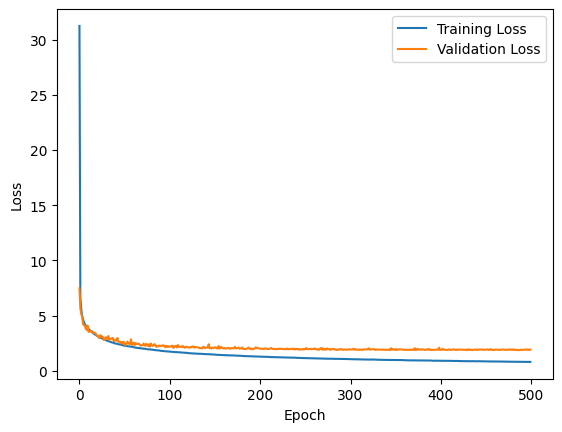

In [637]:
import torch
from torch import nn
from torch_geometric.nn import TransformerConv, GCNConv, GATv2Conv, DeepGCNLayer

import torch_geometric
#from .create_dataset import GraphDataset

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors

import numpy as np
from itertools import combinations
import pandas as pd
import torch.utils.data
import torch.nn.functional as F
# from mordred import Calculator, descriptors
# from padelpy import from_smiles
%matplotlib inline
import matplotlib.pyplot as plt

MODEL_SAVE_PATH = 'best_model.pt'
ATOM_PROPS = ['GetChiralTag', 'GetDegree', 'GetExplicitValence',
             'GetFormalCharge', 'GetHybridization', 'GetImplicitValence',
             'GetIsAromatic', 'GetNoImplicit', 'GetNumExplicitHs',
             'GetNumImplicitHs', 'GetNumRadicalElectrons',
             'GetTotalDegree', 'GetTotalNumHs', 'GetTotalValence']
BOND_PROPS = ['GetBondType', 'GetIsConjugated', 'IsInRing', 'GetStereo']
NUM_NODE_FEATURES = len(ATOM_PROPS) + 2
#NUM_NODE_FEATURES = 58
NUM_EDGE_FEATURES = 6
LOSS_FN = nn.L1Loss
LEARNING_RATE = 0.0001
HIDDEN_CHANNELS = 16
NUM_LAYERS = 6
NUM_LIN_LAYERS = 4
NUM_EPOCHS = 500
BATCH_SIZE = 1
DROPOUT = 0
device = torch.device('cuda')


class MyGCNModel(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_channels, num_layers, dropout=0, num_lin_layers=0):
        super(MyGCNModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        
        self.convs = nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
                              
        # self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin1 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index)
        x = x.relu()
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = x.relu()
        
        x = self.lin1(x)
        return x
    
class DeepGCN(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_channels, num_layers, dropout=0, num_lin_layers=0):
        super(DeepGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        
        self.convs = nn.ModuleList()
        for i in range(num_layers - 1):
            conv = GCNConv(hidden_channels, hidden_channels)
            norm = nn.LayerNorm(hidden_channels)
            act = nn.ReLU(inplace=True)
            deepgcn = DeepGCNLayer(conv, norm, act, block='res+')
            self.convs.append(deepgcn)
                              
        self.lin1 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index)
        x = x.relu()
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
        
        x = self.lin1(x)
        return x

class GraphConvNet(nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_channels, num_layers, dropout=0.0):
        super(GraphConvNet, self).__init__()

        self.conv1 = GATv2Conv(num_node_features, hidden_channels, add_self_loops=False, edge_dim=num_edge_features)

        self.convs = nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(GATv2Conv(hidden_channels, hidden_channels, add_self_loops=False)) #edge_dim=num_edge_features))
        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, 1)

        self.bn1 = nn.LayerNorm(hidden_channels)
        self.bn2 = nn.LayerNorm(hidden_channels)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr):
        #print(x.shape, edge_attr.shape, edge_index.shape)
        x = x.view(-1, x.size(-1))  # flatten node features
        #edge_index = edge_index.view(-1, 2)  # flatten edge indices
        x = self.conv1(x, edge_index, edge_attr)  
        x = x.relu()
        x = self.bn1(x)
        x = self.dropout(x)
        h = x
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)#, edge_attr)
            x = x.relu()
            x = self.bn2(x)
            x = self.dropout(x)
            x = h + x
            h = x
        x = self.lin1(x)
        x = x.relu()
        x = self.dropout(x)
        x = self.lin2(x)
        return x
    
    
class GraphTransformer(nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_channels, num_layers, num_lin_layers=0, dropout=0.0):
        super(GraphTransformer, self).__init__()

        self.conv1 = TransformerConv(num_node_features, hidden_channels, heads=4, edge_dim=num_edge_features)# ,concat=True)

        self.convs = nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(TransformerConv(hidden_channels * 4, hidden_channels, heads=4, edge_dim=num_edge_features))#, concat=True))
        self.lin1 = nn.Linear(hidden_channels * 4, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, 1)
        
        self.lins = nn.ModuleList()
        for i in range(num_lin_layers):
            self.lins.append(nn.Linear(hidden_channels, hidden_channels))

        self.lns_conv = nn.ModuleList([nn.LayerNorm(hidden_channels*4) for _ in range(num_layers)])
        self.ln1 = nn.LayerNorm(hidden_channels*1)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr):
        #print('Input x shape', x.shape, 'Edge Attr shape', edge_attr.shape, 'Edge Index shape', edge_index.shape)
        x = self.conv1(x, edge_index, edge_attr)  
        x = self.lns_conv[0](x)
        x = x.relu()
        x = self.dropout(x)
        h = x
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_attr)
            x = self.lns_conv[i+1](x)
            x = x.relu()
            x = self.dropout(x)
            x = h + x
            h = x
            
        x = self.lin1(x)
        x = self.ln1(x)
        x = x.relu()
        x = self.dropout(x)
        for i, lin in enumerate(self.lins): 
            x = lin(x)
            x = x.relu()
            x = self.dropout(x)
        
        node_embeddings = x
        x = self.lin2(x)
        return x



from torch.nn.utils.rnn import pad_sequence


from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

def generate_edge_features(mols, max_atoms):
    num_molecules = len(mols)
    # max_atoms = max([mol.GetNumAtoms() for mol in mols])
    edge_features = np.zeros((num_molecules, max_atoms, max_atoms, NUM_EDGE_FEATURES))

    # TODO: Bond type information into edge matrix, single bond / aromatic
    # Bond distance as a variable
    # Loop over each molecule and construct the edge adjacency matrix
    # Combine edge features and node edges
    
    for i, mol in enumerate(mols):
        dist_mat = Chem.Get3DDistanceMatrix(mol)
        num_atoms = mol.GetNumAtoms()
        #edge_features = np.zeros((num_atoms * (num_atoms - 1) // 2, 2))  # 2 features: bond distance and bond type

        idx = 0
        for j, k in combinations(range(num_atoms), 2):
            bond = mol.GetBondBetweenAtoms(j, k)
            bond_type = bond.GetBondType() if bond is not None else Chem.rdchem.BondType.ZERO
            bond_isconjugated = int(bond.GetIsConjugated()) if bond is not None else 0 
            bond_inring = int(bond.IsInRing()) if bond is not None else 0
            bond_stereo = int(bond.GetStereo()) if bond is not None else 0
            bond_direction = int(bond.GetBondDir()) if bond is not None else 0
            
            #if bond_type != Chem.rdchem.BondType.ZERO:
            if dist_mat[j,k] < 2: 
                edge_features[i, j, k, 0] = 1
                edge_features[i, k, j, 0] = 1
                edge_features[i, j, k, 1] = bond_type
                edge_features[i, k, j, 1] = bond_type
                edge_features[i, j, k, 2] = bond_isconjugated
                edge_features[i, k, j, 2] = bond_isconjugated
                edge_features[i, j, k, 3] = bond_inring
                edge_features[i, k, j, 3] = bond_inring
                edge_features[i, j, k, 4] = bond_stereo
                edge_features[i, k, j, 4] = bond_stereo
                edge_features[i, j, k, 5] = bond_direction
                edge_features[i, k, j, 5] = bond_direction
            idx += 1

    return edge_features


def generate_features(rdkit_mols, max_atoms, num_bonds=0, num_feats=NUM_NODE_FEATURES):
    atomic_features_list = []
    for mol in rdkit_mols:
        if mol is not None:
            num_atoms = mol.GetNumAtoms()
            atom_features_list = []
            for i, atom in enumerate(mol.GetAtoms()):
                position = mol.GetConformer().GetAtomPosition(i)
                #features = [0] * num_feats
                features = []

                # atom type
                features.append(atom.GetAtomicNum())
                features.append(int(atom.IsInRing()))
                # features.append(position.x)
                # features.append(position.y)
                # features.append(position.z)
                features += [getattr(atom, prop)() for prop in ATOM_PROPS]
                
#                 features[atom.GetAtomicNum() - 1] = 1

#                 # hybridization
#                 hybridization = atom.GetHybridization()
#                 features[9 + hybridization] = 1
#                 #features[1] = atom.GetHybridization()

#                 # degree
#                 degree = atom.GetDegree()
#                 features[15 + degree] = 1
#                 #features[2] = atom.GetDegree()
    
#                 # number of pi electrons
#                 n_pi = atom.GetNumRadicalElectrons()
#                 features[21 + n_pi] = 1
#                 #features[3] = atom.GetNumRadicalElectrons()
    
#                 # number of lone pairs
#                 n_lone_pairs = atom.GetNumImplicitHs()
#                 features[25 + n_lone_pairs] = 1
#                 #features[4] = atom.GetNumImplicitHs()
    
#                 # formal charge
#                 formal_charge = atom.GetFormalCharge()
#                 features[31 + formal_charge] = 1
#                 #features[5] = atom.GetFormalCharge()
    
#                 # in-ring
#                 in_ring = atom.IsInRing()
#                 features[39 + int(in_ring)] = 1
#                 #features[6] = int(atom.IsInRing())

#                 # number of bonds to an atom with atomic number > 7
#                 num_bonds_higher_than_7 = 0
#                 for neighbor in atom.GetNeighbors():
#                     if neighbor.GetAtomicNum() > 7:
#                         num_bonds_higher_than_7 += 1
#                 features[41 + num_bonds_higher_than_7] = 1
                
                

                atom_features_list.append(features)
                

            # Pad the list of atomic features to the maximum number of atoms
            atom_features_list += [[0] * (num_feats + num_bonds)] * (max_atoms - num_atoms)

            # Append the list of atomic features to the list of atomic features for all molecules
            atomic_features_list.append(atom_features_list)

    # Convert the list of atomic features for all molecules to a tensor
    atomic_features_tensor = torch.tensor(atomic_features_list, dtype=torch.float32)

    # Reshape the tensor to (num_molecules, max_atoms, num_features)
    atomic_features_tensor = atomic_features_tensor.view(-1, max_atoms, num_feats + num_bonds)

    return atomic_features_tensor




def mask_shifts(df):
  # Create a list to store the chemical shifts for each molecule
  shifts_list = []

  # Loop over each molecule and construct a list of chemical shifts for the atoms in the molecule
  for i, row in df.iterrows():
      shifts_dict = row['labels']
      num_atoms = row['num_atoms']
      # Create a list of chemical shifts for the atoms in the molecule
      shifts = []
      for atom_idx in range(num_atoms):
          # Check if the current atom has a chemical shift
          if atom_idx in shifts_dict:
              shifts.append(shifts_dict[atom_idx])
          else:
              # If the atom does not have a chemical shift, append a dummy value (e.g., 0)
              shifts.append(0)
      # Append the list of chemical shifts to the shifts_list
      shifts_list.append(shifts)

  max_atoms = df['num_atoms'].max()
  # Pad the sequences in the shifts_list with a dummy value to make them all the same length
  shifts_padded = pad_sequence([torch.tensor(shifts) for shifts in shifts_list], batch_first=True, padding_value=0)

  # Create a new mask tensor that has the same shape as shifts_padded and contains ones for valid atoms and zeros for padded atoms
  mask_padded = torch.zeros(shifts_padded.shape)
  for i, shifts in enumerate(shifts_list):
      for j, shift in enumerate(shifts):
          if shift != 0:
              mask_padded[i, j] = 1

  # Convert mask_padded to a boolean tensor
  mask = mask_padded.long()
  # Pad the mask tensor
  #mask = nn.functional.pad(mask, pad=(0, max_atoms - mask.shape[1]))

  return shifts_padded, mask

def create_graph_data(mols):
    # Initialize the edge adjacency matrix
    num_molecules = len(mols)
    max_atoms = max([mol.GetNumAtoms() for mol in mols])
    print("max atoms", max_atoms)
    edge_adj_matrix = np.zeros((num_molecules, max_atoms, max_atoms))

    # TODO: Bond type information into edge matrix, single bond / aromatic
    # Bond distance as a variable
    # Loop over each molecule and construct the edge adjacency matrix
    # Combine edge features and node edges
    # for i, mol in enumerate(mols):
    #     if mol is not None:
    #         # Extract the atom indices and distances for the edges
    #         dist_mat = Chem.Get3DDistanceMatrix(mol)
    #         for j, k in combinations(range(mol.GetNumAtoms()), 2):
    #             if dist_mat[j, k] <= 2:
    #                 edge_adj_matrix[i, j, k] = 1
    #                 edge_adj_matrix[i, k, j] = 1

    # Generate a list of atomic features for each molecule
    atomic_features_list = generate_features(mols, max_atoms)
    edge_features_matrix = generate_edge_features(mols, max_atoms)
    #print(atomic_features_list[0][0])
    
    #adj_padded = torch.zeros(num_molecules, max_atoms, max_atoms, NUM_EDGE_FEATURES)
    #adj_padded[0, :mols[0].GetNumAtoms(), :mols[0].GetNumAtoms()] = torch.tensor(edge_features_matrix[0], dtype=torch.int64)
    #print(edge_features_matrix[0].nonzero(as_tuple=False))

    return atomic_features_list, edge_features_matrix


def collate_fn(batch):
    # Pad the input data and labels to the maximum number of atoms in the batch
    x = [data[0] for data in batch]
    y = [data[1] for data in batch]
    adj = [data[2] for data in batch]
    mask = [data[3] for data in batch]
    mol_ids = [data[4] for data in batch]
    num_atoms = [data[1].shape[0] for data in batch]
    max_atoms = max(num_atoms)

    # Pad the labels tensor to have the same number of atoms for all samples in the batch
    y_padded = torch.zeros(len(batch), max_atoms)
    for i in range(len(batch)):
        y_padded[i, :num_atoms[i]] = y[i]

    # Pad the input data, adjacency, and mask tensors
    x_padded = torch.zeros(len(batch), max_atoms, x[0].shape[1])
    adj_padded = torch.zeros(len(batch), max_atoms, max_atoms, NUM_EDGE_FEATURES)
    mask_padded = torch.zeros(len(batch), max_atoms)
    for i in range(len(batch)):
        x_padded[i, :num_atoms[i], :] = x[i]
        adj_padded[i, :num_atoms[i], :num_atoms[i], :] = torch.tensor(adj[i], dtype=torch.float32)
        mask_padded[i, :num_atoms[i]] = mask[i]

    y_masked = y_padded * mask_padded
    edge_index = []
    edge_attr = []
    for i in range(len(batch)):
        edge = adj_padded[i].nonzero(as_tuple=False)
        row, col = edge[:, 0], edge[:, 1]
        edge_index.append(torch.stack([row, col], dim=0))
        edge_attr.append(torch.tensor(adj_padded[i, row, col])[:, 1:])
        #print(edge_attr[-1])# Modified line
    edge_index = torch.cat(edge_index, dim=1)
    edge_attr = torch.cat(edge_attr, dim=0)#.unsqueeze(-1)

    #edge_attr = edge_attr.unsqueeze(-1)
    mask_padded = mask_padded.unsqueeze(-1)
    y_masked = y_masked.unsqueeze(-1)

    # print('Adjacency matrix padded', adj_padded.shape)
    # print('Edge attr shape', edge_attr.shape)
    # print('Edge index shape', edge_index.shape)
    # print('Mask padded shape', mask_padded.shape)
    # print('X padded shape', x_padded.shape)
    # print('Y padded shape', y_padded.shape)

    # Apply the mask to the padded labels tensor
    ##y_masked = y_padded * mask_padded

    return x_padded, y_masked, edge_index, edge_attr, mask_padded.long(), mol_ids


from torch_geometric.utils import to_dense_batch
best_model = None

def plot_losses(train_losses, valid_losses):
    plt.clf()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    #plt.show()
    plt.savefig('loss_curves.png')
    
    
def move_to_device(device, x, y, edge_idx, edge_attrs, mask):
    return x.to(device), y.to(device), edge_idx.to(device), edge_attrs.to(device), mask.to(device)

def train_graph_transformer(train_data_loader, valid_data_loader, model, optimizer, num_epochs=100, batch_size=1):
    # Train the model
    best_val_loss = float('inf')
    train_losses = []
    valid_losses = []
    #model.to(device)
    for epoch in range(num_epochs):
        jorgensen_decay_lr(optimizer, epoch, init_lr=LEARNING_RATE, decay_factor=0.96)
        model.train()
        total_loss = 0.0
        for x, y, edge_indices, edge_attrs, train_mask, _ in train_data_loader:
            out = model(x, edge_indices, edge_attrs)
            #loss = nn.functional.calc_loss(out, y)
            loss, _, _ = calc_loss(out, y, train_mask)
            total_loss += loss.item() * x.shape[0]

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # clip_value = 1 # set the maximum gradient norm
            # for param in model.parameters():
            #     param.grad.data.clamp_(-clip_value, clip_value) # clip the gradients
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1) 
            optimizer.step()

        avg_train_loss = total_loss / len(train_data_loader)

        # Evaluate the model on the validation set
        model.eval()
        with torch.no_grad():
            total_loss = 0.0
            for x, y, edge_indices, edge_attrs, valid_mask, _ in valid_data_loader:            
                out = model(x, edge_indices, edge_attrs)
                #loss = nn.functional.calc_loss(out, y)
                loss, _, _ = calc_loss(out, y, valid_mask)
                total_loss += loss.item() * x.shape[0]

            # Compute the average validation loss
            avg_valid_loss = total_loss / len(valid_data_loader)
            if avg_valid_loss < best_val_loss:
              best_val_loss = avg_valid_loss
              best_model = model.state_dict()
              torch.save(best_model, MODEL_SAVE_PATH)
              test(model, test_loader_c)
              test(model, test_loader_h)

        print(f"Epoch {epoch + 1}/{num_epochs}: validation loss={avg_valid_loss:.4f}")
        print(f"Epoch {epoch + 1}/{num_epochs}: train loss={avg_train_loss:.4f}")
        train_losses.append(avg_train_loss)
        valid_losses.append(avg_valid_loss)
        plot_losses(train_losses, valid_losses)

    return model


def test(model, loader, best_model=None):
    # print('new test set ------ ')
   # Evaluate the model on the validation set
    model.load_state_dict(best_model) if best_model else None
    model.eval()
    all_y_pred, all_y_true = [], []
    with torch.no_grad():
        total_loss = 0.0
        for x, y, edge_indices, edge_attrs, mask, mol_id in loader:
            out = model(x, edge_indices, edge_attrs)
            #loss = nn.functional.calc_loss(out, y)
            loss, y_pred, y_true = calc_loss(out, y, mask, loss_fn=nn.L1Loss)
            #print('loss', loss, mol_id)
            total_loss += loss.item() * x.shape[0]
            all_y_pred += y_pred
            all_y_true += y_true

        # Compute the average validation loss
        avg_mol_loss = total_loss / len(loader)
        avg_atom_loss = nn.L1Loss()(torch.tensor(all_y_pred), torch.tensor(all_y_true))
      
    print(f"Test Mol loss={avg_mol_loss:.4f}, Test Atom loss={avg_atom_loss:.4f}")

def check_if_values_are_too_large(tensor, threshold):
    return (tensor < threshold).any()

def jorgensen_decay_lr(optimizer, epoch, init_lr=0.001, decay_factor=0.1):
    div = (epoch / 30)
    if (epoch % 30) == 0:
        lr = init_lr * (decay_factor ** div)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


def calc_loss(y_pred, y_true, atom_indices, loss_fn=LOSS_FN):
    #atom_indices = atom_indices.unsqueeze(0)  # Add a new dimension at the beginning
    #print(y_true.nonzero())
    mask = atom_indices.bool().squeeze(2)  # Convert atom_indices to a boolean mask
    y_pred = y_pred.squeeze(2)[mask]  # Select relevant elements of y_pred
    y_true = y_true.squeeze(2)[mask]  # Select relevant elements of y_true
    #loss = F.calc_loss(y_pred, y_true)
    loss_fn = loss_fn()
    loss = loss_fn(y_pred, y_true)

    if torch.isnan(loss):
        #print("NaN loss detected. Excluding from the loss calculation.")
        loss[torch.isnan(loss)] = 0.0

    # print('y_pred y_true', y_pred, y_true)
    # print(loss)
    return loss, y_pred.tolist(), y_true.tolist()


def create_data_loader(df, batch_size=1):
  # Create the train and validation graph data
  atomic_features, edge_adj_matrix = create_graph_data(df['mol'])
  x = atomic_features
  # Create the train and validation label tensors
  y, mask = mask_shifts(df)
  graph_dataset = GraphDataset(x, y, edge_adj_matrix, mask, df['mol_id'])
  return DataLoader(graph_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

def transfer_learn_model(model):
    state_dict = torch.load('best_model_c_exp.pt')
    model.load_state_dict(state_dict)
    # Freeze all parameters
#     for param in model.parameters():
#         param.requires_grad = False

#     # Make last two linear layers trainable
#     for param in model.lin1.parameters():
#         param.requires_grad = True

#     for param in model.lin2.parameters():
#         param.requires_grad = True
#     for param in model.lins.parameters():
#         param.requires_grad = True



# Define the hyperparameters
num_node_features = NUM_NODE_FEATURES
num_edge_features = NUM_EDGE_FEATURES - 1 #Exlcude the boolean edge exists feature
hidden_channels = HIDDEN_CHANNELS
num_layers = NUM_LAYERS
num_lin_layers = NUM_LIN_LAYERS
num_epochs = NUM_EPOCHS
batch_size = BATCH_SIZE
learning_rate = LEARNING_RATE
dropout = DROPOUT

train_loader = create_data_loader(train_df)
valid_loader = create_data_loader(valid_df)
test_loader_c  = create_data_loader(test_df_c)
test_loader_h  = create_data_loader(test_df_h)

# Create the model
model = GraphTransformer(num_node_features, num_edge_features, hidden_channels, num_layers, num_lin_layers=num_lin_layers, 
                         dropout=dropout)
# Fine tuning the saved model from state_dict
#transfer_learn_model(model)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

# Train the model
model = train_graph_transformer(train_loader, valid_loader, model, optimizer, 
                                num_epochs=num_epochs, batch_size=batch_size)


best_model = torch.load('best_model.pt')

test(model, test_loader_c, best_model)
test(model, test_loader_h, best_model)

# Create an example input
# x = torch.randn(batch_size, num_node_features)
# edge_index = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 0]])

# Print the summary
# summary(model, ([batch_size, num_node_features], [2, edge_index.size(1)]), device='cpu')



In [513]:
!python --version

import torch
import torch_geometric
import rdkit

torch.cuda.current_device() # returns 0 in my case

print(torch.__version__)
print(torch_geometric.__version__)
print(rdkit.__version__)

# get number of GPUs available
torch.cuda.device_count() # returns 1 in my case


# get the name of the device
device = torch.device('cuda')
torch.cuda.get_device_name(0)
print(device)


Python 3.9.16
1.13.1+cu116
2.2.0
2022.09.5
cuda
